In [1]:
import base64
import json
import os
import random
import tempfile
import urllib.parse
import urllib.request
from pathlib import Path

import fairseq
import numpy as np
import requests
from Bio.PDB import PDBParser
from rdkit import Chem

## TamGen: Target-aware Molecule Generation for Drug Design Using a Chemical Language Model

TamGen is a chemical language model that enables target-aware molecule generation and compound refinement, with the goal of accelerating the process of drug design. In this notebook, we provide a basic pipeline that leverages the TamGen model to generate new compounds based on existing protein-ligand structures in the PDB (Protein Data Bank). For more details, please refer to our [article](https://www.nature.com/articles/s41467-024-53632-4) on Nature Communications!

Provide the PDB ID of a protein of interest. A good resource for searching the PDB is [RCSB](https://www.rcsb.org/).

In [2]:
pdb_id = "7vh8"

work_dir = tempfile.mkdtemp("tamgen-foundry-demo")
print(work_dir)

/tmp/tmpms5w96z8tamgen-foundry-demo


We now query RCSB for the ligands associated with this PDB structure. This information is also available on the web interface.

In [3]:
entry_nonpolymer_entity_query = f"""{{
    entry(entry_id: "{pdb_id}") {{
        rcsb_id
        rcsb_entry_container_identifiers {{
            non_polymer_entity_ids
        }}
    }}
}}"""

data = requests.get(f"https://data.rcsb.org/graphql?query={urllib.parse.quote(entry_nonpolymer_entity_query)}")
entity_ids = json.loads(data.text)["data"]["entry"]["rcsb_entry_container_identifiers"]["non_polymer_entity_ids"]
entity_ids = ["_".join([pdb_id, _id]).upper() for _id in entity_ids]

nonpolymer_entities_query = f"""{{
    nonpolymer_entities(entity_ids: {json.dumps(entity_ids)}) {{
        pdbx_entity_nonpoly {{
            name
            comp_id
        }}
        rcsb_nonpolymer_entity_container_identifiers {{
            auth_asym_ids
        }}
    }}
}}"""

data = requests.get(f"https://data.rcsb.org/graphql?query={urllib.parse.quote(nonpolymer_entities_query)}")
nonpolymer_entities = json.loads(data.text)["data"]["nonpolymer_entities"]
nonpolymer_entities = [{k: v for dicts in entity.values() for k, v in dicts.items()} for entity in nonpolymer_entities]

print(json.dumps(nonpolymer_entities, indent=4))

[
    {
        "name": "(1R,2S,5S)-N-{(1E,2S)-1-imino-3-[(3S)-2-oxopyrrolidin-3-yl]propan-2-yl}-6,6-dimethyl-3-[3-methyl-N-(trifluoroacetyl)-L-valyl]-3-azabicyclo[3.1.0]hexane-2-carboxamide",
        "comp_id": "4WI",
        "auth_asym_ids": [
            "A"
        ]
    },
    {
        "name": "DIMETHYL SULFOXIDE",
        "comp_id": "DMS",
        "auth_asym_ids": [
            "A"
        ]
    }
]


Select the pocket (protein-ligand binding site) by specifying the ligand ID (comp_id above) and chain ID (auth_asym_ids above).

In [4]:
ligand_id = "4WI" # comp_id of selected ligand (nonpolymer entity)
chain_id = "A" # auth_asym_id of selected ligand (nonpolymer entity)

#### Data Processing

Before invoking the TamGen model, we need to prepare the relevant information. We first download the structure files of the protein and extract the binding site of the selected ligand.

In [5]:
def download_file(url, output_path):
    with requests.get(url, timeout=5) as r:
        with output_path.open('w') as f:
            f.write(r.content.decode("utf-8"))

input_pdb = Path(work_dir) / f"{pdb_id}.pdb"
input_cif = Path(work_dir) / f"{pdb_id}.cif"
download_file(f"https://files.rcsb.org/download/{pdb_id}.pdb", input_pdb)
download_file(f"https://files.rcsb.org/download/{pdb_id}.cif", input_cif)

print(json.dumps(list(map(str, Path(work_dir).iterdir())), indent=4))

[
    "/tmp/tmpms5w96z8tamgen-foundry-demo/7vh8.cif",
    "/tmp/tmpms5w96z8tamgen-foundry-demo/7vh8.pdb"
]


In [6]:
def get_ligand_center(input_pdb, ligand_name, chain_id):
    parser = PDBParser()
    structure = parser.get_structure('structure', input_pdb)
    
    coords = []
    for model in structure:
        for chain in model:
            if chain.id != chain_id:
                continue
            for residue in chain:
                if residue.resname != ligand_name:
                    continue
                for atom in residue:
                    coords.append(atom.get_coord())
    
    return np.mean(np.array(coords), axis=0).tolist()

ligand_center = get_ligand_center(input_pdb, ligand_id, chain_id)

We query RCSB again for the SMILES (Simple Molecular Input Line Entry System) string representation of the ligand, which we can consider to be the "language" of molecules. The SMILES string is augmented by constructing other equivalent representations of the same molecule, which helps to diversify the output.

In [7]:
ligand_query = f"""{{
    chem_comp(comp_id: "{ligand_id}") {{
        rcsb_id
        rcsb_chem_comp_descriptor {{
            SMILES
        }}
    }}
}}"""

data = requests.get(f"https://data.rcsb.org/graphql?query={urllib.parse.quote(ligand_query)}")
smiles = json.loads(data.text)["data"]["chem_comp"]["rcsb_chem_comp_descriptor"]["SMILES"]

def augment(smiles: str, n_augment: int):
    augmented_smiles = set()

    molecule = Chem.MolFromSmiles(smiles)

    augmented_smiles.add(smiles)
    canonical_smiles = Chem.MolToSmiles(molecule)
    augmented_smiles.add(canonical_smiles)

    indices = list(range(molecule.GetNumAtoms()))  
    for _ in range(n_augment):
        random.shuffle(indices) 
        _molecule = Chem.RenumberAtoms(molecule, indices) 
        candidate_smiles = Chem.MolToSmiles(_molecule, isomericSmiles=True, canonical=False)  

        _molecule = Chem.MolFromSmiles(candidate_smiles)
        if _molecule is None:
            continue
        canonical_candidate_smiles = Chem.MolToSmiles(_molecule)
        if canonical_candidate_smiles == canonical_smiles:
            augmented_smiles.add(candidate_smiles)

    return augmented_smiles

augmented_smiles = augment(smiles, n_augment=3)
print(json.dumps(list(augmented_smiles), indent=4))

[
    "O=C(NC(C(C)(C)C)C(N1C(C(NC(C=N)CC2C(=O)NCC2)=O)C2C(C2(C)C)C1)=O)C(F)(F)F",
    "CC(C)(C)C(NC(=O)C(F)(F)F)C(=O)N1CC2C(C1C(=O)NC(C=N)CC1CCNC1=O)C2(C)C",
    "C(C=N)(NC(C1N(C(C(NC(=O)C(F)(F)F)C(C)(C)C)=O)CC2C(C)(C)C21)=O)CC1CCNC1=O",
    "CC1(C2C1C(N(C2)C(=O)C(C(C)(C)C)NC(=O)C(F)(F)F)C(=O)NC(CC3CCNC3=O)C=N)C",
    "C1C(CC(C=N)NC(C2C3C(CN2C(C(C(C)(C)C)NC(C(F)(F)F)=O)=O)C3(C)C)=O)C(=O)NC1"
]


We now prepare the input data that the model requires. These files are an encoding of the molecule and protein "language" (sequences), and provide the context necessary for target-aware generation of molecules.

In [8]:
output_dir = tempfile.mkdtemp("tamgen-foundry-demo-output")

In [9]:
from fairseq.build_dataset import build_dataset

build_dataset(pdb_id, ligand_center, augmented_smiles, work_dir, output_dir)

Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation', source_lang='tg', target_lang='m1', trainpref=None, validpref=None, testpref='/tmp/tmp4n42kbmptamgen-foundry-demo-output/src/test', destdir='/tmp/tmp4n42kbmptamgen-foundry-demo-output/tmp', thresholdtgt=0, thresholdsrc=0, tgtdict='/home/biran/src/fairseq/dict/dict.m1.txt', srcdict='/home/biran/src/fairseq/dict/dict.tg.txt', nwordstgt=-1, nwordssrc=-1, alignfile=None, dataset_impl='mmap', joined_dictionary=False, only_source=False, padding_factor=8, workers=4)
| [tg] Dictionary: 24 types
| [tg] /tmp/tmp4n42kbmptamgen-foundry-demo-output/src/test.tg: 5 sents, 135 tokens, 0.0%

Query the AI Foundry endpoint with the processed data.

In [10]:
def prepare_payload(input_dir: Path):
  payload = {}
  for path in input_dir.iterdir():
    if path.is_dir():
      continue

    with path.open('rb') as f:
      payload[f"inmemorycache/{path.name}"] = base64.b64encode(f.read()).decode()

  return json.dumps({ "input_data": payload })

def query_endpoint(payload: str):
  url = os.environ["FOUNDRY_URL"]
  api_key = os.environ["FOUNDRY_TOKEN"]

  headers = {
    'Content-Type':'application/json',
    'Authorization':('Bearer '+ api_key),
  }
  body = payload.encode()
  req = urllib.request.Request(url, body, headers)

  try:
    response = urllib.request.urlopen(req)
  except urllib.error.HTTPError as error:
    print(f"The request failed with status code: {error.code}")
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))
    result = None
  else:
    result = json.loads(response.read().decode())

  return result

payload = prepare_payload(Path(output_dir))
result = query_endpoint(payload)

In [11]:
print(json.dumps(result, indent=4))

{
    "result": [
        [
            "CCC1C(C(=O)Nc2cccc(S(=O)(=O)N(CC)CC)c2)=NC(C)=C1C(C)=O",
            -0.17983470112085342
        ],
        [
            "CCC1C(C(=O)Nc2cc(C(F)(F)F)cc(S(=O)(=O)N(CC)CC)c2)=NC(C)=C1C(C)=O",
            -0.18360529839992523
        ],
        [
            "CCC1C(C(=O)Nc2cc(C(F)(F)F)cc(S(=O)(=O)N(CC)CC)c2)=NC(C2CC2)=C1C(C)=O",
            -0.1895076036453247
        ],
        [
            "CCC1C(C(=O)Nc2cc(S(=O)(=O)N(CC)CC)ccc2N2CCN(C)CC2)=NC(C)=C1C(C)=O",
            -0.19663859903812408
        ],
        [
            "CC(=O)NC1=NC2=CC=C(c3cnc(N)c(C(F)(F)F)c3)CN2C1",
            -0.1998922973871231
        ],
        [
            "CC(=O)N1NC(N2CCC(C(=O)O)CC2)=NC1CCC1=NC2=C(C)C=C(Cl)C(C)N2N1",
            -0.20118975639343262
        ],
        [
            "CC(=O)NC1=NC2=CC=C(c3cnc(NC(=O)NC(C)(C)C)c(C(F)(F)F)c3)CN2C1",
            -0.20471671223640442
        ],
        [
            "CC(=O)NC1=NC2=CC=C(c3cnc(NC(C)(C)C)c(C(F)(F)F)c3)CN2C1

The structures of the generated molecules can be visualised using RDKit (only a subset of all generated molecules are shown here).

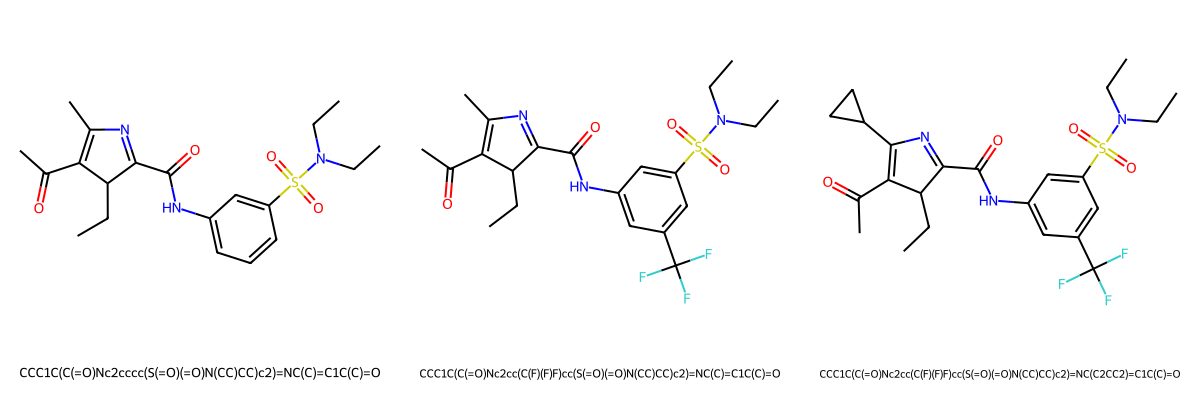

In [12]:
from rdkit.Chem import Draw

candidate_smiles, _ = zip(*result["result"])
candidate_molecules = [Chem.MolFromSmiles(v) for v in candidate_smiles]
Draw.MolsToGridImage(candidate_molecules[:3], legends=candidate_smiles, molsPerRow=3, subImgSize=(400, 400))

#### Docking

We can analyse the conformation and orientation, also known as the "pose", of the generated molecules at the binding site of the target protein. The docking process is performed by [Autodock Vina](https://vina.scripps.edu/).

In [13]:
from Bio.PDB import PDBIO, Select

class CleanPDBSelect(Select):
    def accept_atom(self, atom):
        # Exclude water molecules (HOH) and heteroatoms
        if atom.parent.resname == 'HOH' or atom.parent.id[0] != ' ':
            return False
        # Exclude alternate locations
        if atom.altloc not in (' ', 'A'):
            return False
        return True

def prepare_receptor(pdb_id: str, work_dir: str):
    input_pdb = str(Path(work_dir) / f"{pdb_id}.pdb")
    output_pdb = str(Path(work_dir) / f"{pdb_id}.receptor.pdb")

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', input_pdb)

    io = PDBIO()
    io.set_structure(structure)
    io.save(output_pdb, CleanPDBSelect())

prepare_receptor(pdb_id, work_dir)

In [14]:
from fairseq.docking import attempt_docking

for candidate in candidate_smiles:
    try:
        attempt_docking(pdb_id, ligand_id, chain_id, candidate, ligand_center, work_dir, n_conf=1, timeout=45)
    except TimeoutError:
        continue
    else:
        print(f"Successfully docked: {candidate}")
        break

*** Open Babel Warning  in WriteMolecule
  No 2D or 3D coordinates exist. Stereochemical information will be stored using an Open Babel extension. To generate 2D or 3D coordinates instead use --gen2D or --gen3D.


Successfully docked: CCC1C(C(=O)Nc2cccc(S(=O)(=O)N(CC)CC)c2)=NC(C)=C1C(C)=O


1 molecule converted


The docking pose of the generated molecule can be examined in the 3D structure viewer below.

In [15]:
import nglview

view = nglview.NGLWidget()
view.add_component(str(Path(work_dir) / f"{pdb_id}.receptor.pdb"))
view.add_component(str(Path(work_dir) / f"{ligand_id}_{chain_id}.sdf"))

view.layout.height = '600px'
view

NGLWidget(layout=Layout(height='600px'))